In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the columns where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.iloc[:, data_cols].values
    _, seq_len = data.shape
    X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    return X, y

In [ ]:
#hide
#old
# def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
#export
def SlidingWindow(window_length:int, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
    if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
    get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
    get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
    if horizon == 0 and get_x is not None and get_y is not None:
        assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
        'you need to change either horizon, get_x or get_y to avoid leakage'
    wl = window_length
    ws = wl if stride is None else stride
    start = start if start is not None else np.random.choice(ws, 1)[0]
    def _inner(o):
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            columns = o.columns.values if seq_first else o.T.columns.values
            o = o.values
            if o.ndim > 1: 
                if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
                elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
                else: _get_x = slice(None)
                _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
        elif o.ndim > 1: 
            _get_x = ifnone(get_x, slice(None))
            _get_y = ifnone(get_y, slice(None))
        if seq_first: o = o.T
        o = o.squeeze()
        _seq_len = o.shape[-1]
        assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
        x, y = [], []
        for i in range(start, _seq_len - wl - horizon + 1, ws):
            if o.ndim == 1: 
                x.append(o[..., slice(i, i + wl)])
                if get_y is not None or horizon > 0:
                    if y_func is not None:
                        y.append(y_func(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))]))
                    else: 
                        y.append(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))])
            else: 
                x.append(o[..., _get_x, slice(i, i + wl)])
                if get_y is not None or horizon > 0:
                    if y_func is not None: 
                        y.append(y_func(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i, i + wl))]))
                    else: 
                        y.append(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i + wl - 1, i + wl))])
        X = to3d(stack(x))
        if X.dtype == 'O': X = X.astype(np.float32)
        y = stack(y).squeeze() if y != [] else None
        return X, y
    return _inner

In [ ]:
#export
def SlidingWindowPanel(df, window_length:int, unique_id_cols:list, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True):
    
    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        unique_id_cols  = columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon. If None, get_y will be returned.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
    key = df[unique_id_cols].values
    unique_id_values = df[unique_id_cols].drop_duplicates().values
    _x = []
    _y = []
    for v in unique_id_values: 
        x_v, y_v = SlidingWindow(window_length, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                 horizon=0, seq_first=seq_first)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])
        _x.append(x_v)
        if y_v is not None: _y.append(y_v)
    X = concat(*_x)
    y = concat(*_y) if len(_y) > 0 else None
    return X, y, key

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#6) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),),(array([[5, 6, 7, 8, 9]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, start=None)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


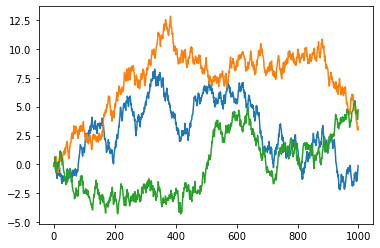

[(array([[-0.07785443,  0.13794784, -0.03080749,  0.23819834,  0.01722819],
       [ 0.1235475 , -0.13174655, -0.0518818 ,  0.32304225, -0.15232356]]), 0.6644142527343602), (array([[-0.37624297, -0.52540737, -0.650937  , -0.48544156, -0.82724117],
       [ 0.20097439,  0.36685822,  0.59304429,  0.66182839,  0.25819091]]), -0.7172514579403794), (array([[-1.10846948, -1.21396411, -0.85278677, -0.89547015, -0.94862496],
       [-0.10823002, -0.00652388, -0.19626978, -0.45658679, -0.69499788]]), -0.26145037650115033), (array([[-0.68971422, -0.19709035, -0.64691293, -0.49938064, -0.29691051],
       [-0.51182787, -0.32649605, -0.36401493,  0.07778106,  0.55673575]]), 0.6321919873324656), (array([[-0.78145884, -1.04246618, -0.80114749, -0.83728328, -0.85506801],
       [ 0.33476547,  0.29847555,  0.43777173,  0.4424128 ,  0.92138802]]), 1.0645469861662145), (array([[-1.27415785, -1.5035498 , -1.64415191, -1.21562152, -0.97555815],
       [ 0.85354419,  0.41051061, -0.07611128,  0.20440312,  

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,0.413328,-0.144696,-0.026986
1,0.147894,0.180818,0.460784
2,0.582648,-0.262288,0.165531
3,0.252837,0.232609,0.213887
4,0.636611,0.002432,0.264914
...,...,...,...
95,-2.568933,-1.628417,-0.093116
96,-2.346364,-1.893762,-0.273660
97,-2.466952,-1.776151,-0.066014
98,-2.299128,-1.854640,0.234717


[(array([[ 0.41332755,  0.14789413,  0.58264816,  0.25283728,  0.63661066],
       [-0.14469571,  0.18081805, -0.26228847,  0.23260936,  0.00243158]]), 0.26491354696179914), (array([[ 0.14789413,  0.58264816,  0.25283728,  0.63661066,  1.04899174],
       [ 0.18081805, -0.26228847,  0.23260936,  0.00243158, -0.22431352]]), -0.08241172960344578), (array([[ 0.58264816,  0.25283728,  0.63661066,  1.04899174,  1.18148048],
       [-0.26228847,  0.23260936,  0.00243158, -0.22431352, -0.082193  ]]), -0.1486856287331395), (array([[ 0.25283728,  0.63661066,  1.04899174,  1.18148048,  1.10881818],
       [ 0.23260936,  0.00243158, -0.22431352, -0.082193  , -0.25183849]]), 0.09016821977482647), (array([[ 0.63661066,  1.04899174,  1.18148048,  1.10881818,  0.76720143],
       [ 0.00243158, -0.22431352, -0.082193  , -0.25183849, -0.08608482]]), 0.543264300762473), (array([[ 1.04899174,  1.18148048,  1.10881818,  0.76720143,  0.57902505],
       [-0.22431352, -0.082193  , -0.25183849, -0.08608482, 

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.041766,0.280359,0.298335,-0.085707,0.321792
1,-0.420024,-0.100067,0.674803,0.303369,0.533977
2,-0.054396,-0.578723,0.879890,-0.144017,1.028910
3,-0.208555,-0.401097,1.020190,-0.562481,1.457071
4,-0.486148,0.020018,1.254937,-0.986723,1.649160
...,...,...,...,...,...
95,-4.543587,-0.152502,4.573322,-0.685144,0.335032
96,-4.130465,-0.315579,5.026081,-0.856798,0.790059
97,-4.012236,-0.197050,4.653973,-1.305659,0.955715
98,-3.883062,0.230891,4.651334,-1.790167,0.536235


[(array([[-0.04176626, -0.42002436, -0.05439558, -0.20855527, -0.48614816],
       [ 0.28035903, -0.10006663, -0.57872269, -0.40109705,  0.02001795],
       [ 0.2983346 ,  0.67480279,  0.87989019,  1.02019035,  1.25493662],
       [-0.08570727,  0.30336859, -0.14401735, -0.56248085, -0.98672334]]), 1.6491601345458942), (array([[-0.42002436, -0.05439558, -0.20855527, -0.48614816, -0.87317653],
       [-0.10006663, -0.57872269, -0.40109705,  0.02001795,  0.19526298],
       [ 0.67480279,  0.87989019,  1.02019035,  1.25493662,  1.17895368],
       [ 0.30336859, -0.14401735, -0.56248085, -0.98672334, -0.92387831]]), 1.182907299412252), (array([[-0.05439558, -0.20855527, -0.48614816, -0.87317653, -1.13396689],
       [-0.57872269, -0.40109705,  0.02001795,  0.19526298,  0.03436602],
       [ 0.87989019,  1.02019035,  1.25493662,  1.17895368,  0.73959517],
       [-0.14401735, -0.56248085, -0.98672334, -0.92387831, -0.75927114]]), 0.9226215626727821), (array([[-0.20855527, -0.48614816, -0.87

       [-0.68514395, -0.8567977 , -1.30565948, -1.79016686, -1.6407479 ]]), 0.09005727111641415)]


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.351198,-0.082594,-0.525823,-0.470604,-0.497307,-0.304836,-0.633040,-0.857752,-1.247748,-0.936039,...,3.416872,3.237789,3.311724,3.259629,3.653040,3.205247,3.009870,2.551713,2.963437,3.399778
var_1,0.169390,0.644302,0.223558,0.107411,-0.109975,-0.146082,-0.307911,0.006000,0.153981,0.338962,...,-1.123423,-0.825747,-1.279379,-1.511480,-1.185964,-1.264732,-1.309988,-1.677197,-1.754807,-1.362356
var_2,0.099948,-0.388861,-0.237418,0.183686,0.638080,0.618432,0.220582,0.362924,0.111660,0.281572,...,-5.607135,-5.828348,-5.792511,-5.799288,-5.497840,-5.923804,-5.733546,-6.087814,-6.448713,-6.435256
var_3,-0.473898,-0.705756,-1.100339,-1.016987,-1.411823,-1.526123,-1.222514,-1.032970,-1.149263,-1.558346,...,-5.440878,-5.612529,-6.107043,-5.732310,-6.138340,-5.919625,-6.054309,-5.703126,-5.811781,-6.222066
target,0.343035,-0.106362,0.388523,0.239056,0.309563,0.113213,0.199188,-0.041005,0.397769,0.179656,...,0.816323,0.753978,0.420690,0.233594,0.099896,0.278253,0.686926,1.182781,0.711317,0.373887


[(array([[-0.35119782, -0.08259391, -0.52582253, -0.47060431, -0.49730731],
       [ 0.16938974,  0.64430169,  0.22355792,  0.10741069, -0.10997469],
       [ 0.09994807, -0.38886055, -0.23741793,  0.18368588,  0.63808008],
       [-0.47389759, -0.70575617, -1.10033919, -1.01698668, -1.41182255]]), 0.3095625610399563), (array([[-0.08259391, -0.52582253, -0.47060431, -0.49730731, -0.30483644],
       [ 0.64430169,  0.22355792,  0.10741069, -0.10997469, -0.14608234],
       [-0.38886055, -0.23741793,  0.18368588,  0.63808008,  0.61843183],
       [-0.70575617, -1.10033919, -1.01698668, -1.41182255, -1.52612323]]), 0.11321288275213703), (array([[-0.52582253, -0.47060431, -0.49730731, -0.30483644, -0.63304006],
       [ 0.22355792,  0.10741069, -0.10997469, -0.14608234, -0.30791085],
       [-0.23741793,  0.18368588,  0.63808008,  0.61843183,  0.22058157],
       [-1.10033919, -1.01698668, -1.41182255, -1.52612323, -1.22251388]]), 0.19918755990236658), (array([[-0.47060431, -0.49730731, -0

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.254924,0.130902,-0.064081,-0.039932,-0.502981,-0.787742,-1.097020,-1.165589,-0.970950,-0.591873,...,-4.412889,-4.833601,-4.909974,-5.318807,-5.676493,-5.725270,-5.902072,-5.892391,-5.562212,-5.660867
var_1,-0.031676,-0.226630,-0.539734,-0.397248,-0.871357,-1.294626,-0.935371,-1.307250,-1.478589,-1.102874,...,-4.054295,-4.050507,-4.118816,-4.430464,-4.771347,-5.115550,-4.911243,-4.615927,-4.195972,-4.382972
var_2,-0.138984,-0.398794,-0.094916,0.278974,0.342100,-0.057258,0.056235,0.542660,0.513213,0.221070,...,-5.017734,-5.320083,-5.201886,-5.384423,-4.967673,-4.697489,-4.685739,-4.433694,-4.600244,-4.599668
var_3,-0.421274,-0.636055,-0.926671,-0.467735,-0.683950,-1.011756,-1.000936,-0.987186,-1.293996,-1.079645,...,-1.513724,-1.844920,-1.626636,-1.852012,-1.784216,-2.048053,-1.831065,-1.806008,-1.991483,-1.667358
target,0.295880,0.364278,-0.112721,-0.154659,0.170376,0.420829,0.144452,0.057277,-0.067465,-0.047399,...,0.830449,0.611534,0.197135,0.545687,0.320425,0.603994,0.639292,0.481810,0.680784,0.305529


[(array([[-0.25492438,  0.13090189, -0.06408086, -0.03993155, -0.50298145],
       [-0.03167619, -0.22662984, -0.53973357, -0.39724791, -0.87135713],
       [-0.13898356, -0.39879439, -0.09491574,  0.27897391,  0.34209979],
       [-0.42127367, -0.63605497, -0.92667067, -0.46773478, -0.68395028]]), 0.17037617187732257), (array([[-0.78774174, -1.09702032, -1.16558875, -0.97095015, -0.59187281],
       [-1.29462575, -0.9353707 , -1.30725003, -1.47858942, -1.10287403],
       [-0.05725832,  0.05623517,  0.54266002,  0.51321292,  0.2210704 ],
       [-1.01175602, -1.00093644, -0.98718578, -1.29399589, -1.07964461]]), -0.04739920761526428), (array([[-0.41401159, -0.32680124, -0.81137595, -0.51619917, -0.57480535],
       [-1.46165362, -1.34070042, -1.48442143, -1.12948685, -0.90426975],
       [-0.13037119, -0.60248918, -0.68826948, -0.62569151, -0.87924419],
       [-0.95575262, -0.90540973, -1.28129126, -1.10524026, -0.98046014]]), 1.1791533336025917), (array([[-1.05707088, -0.70259913, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.040789,-0.173321,0.239534,0.034330,-0.037672
1,0.145856,-0.172253,0.551011,0.017328,-0.469012
2,0.621180,-0.578187,0.393658,-0.314616,-0.361017
3,0.369557,-0.595533,0.350955,-0.471430,-0.452818
4,0.122435,-1.042657,-0.070018,-0.618120,-0.315762
...,...,...,...,...,...
95,-1.043586,-2.327701,1.239405,2.071766,-3.202513
96,-1.447174,-2.035866,1.207408,2.557826,-3.220428
97,-1.857033,-2.130341,1.265869,2.910888,-3.110168
98,-2.054408,-1.710026,1.604671,2.919724,-2.680927


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(20)]).T * tensor([1, 10, 100]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(20)
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df = df.append(df2).append(df3).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,var_0,var_1,var_2,time,device,target
0,6,60,600,6,0,0
1,19,172,1702,17,2,3
2,5,50,500,5,0,1
3,15,132,1302,13,2,3
4,9,90,900,9,0,1
5,18,162,1602,16,2,3
6,10,82,802,8,2,2
7,11,110,1100,11,0,0
8,6,42,402,4,2,3
9,3,21,201,2,1,2


In [ ]:
X, y, key = SlidingWindowPanel(df, 5, unique_id_cols=['device'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True)

X.shape, y.shape, key.shape

((48, 3, 5), (48,), (60, 1))

In [ ]:
X, y, key = SlidingWindowPanel(df, 5, unique_id_cols=['device'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                               y_func=lambda o: np.mean(o), horizon=0, seq_first=True, sort_by=['time'], ascending=True)
X.shape, y.shape, key.shape

((48, 3, 5), (48,), (60, 1))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.R